In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef, roc_curve, precision_recall_curve, auc
from sklearn.calibration import calibration_curve
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# Load your dataset
df = pd.read_csv('diabetes.csv')

# Handle missing values (replace zeros with NaN for specific columns)
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

# Fill missing values with median
for col in columns_with_zeros:
    df[col].fillna(df[col].median(), inplace=True)

# Scale numeric features
scaler = MinMaxScaler()
numeric_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Encode target variable if categorical
df['Outcome'] = df['Outcome'].astype(int)

# Split the dataset
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-3-ec01a1832a32>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


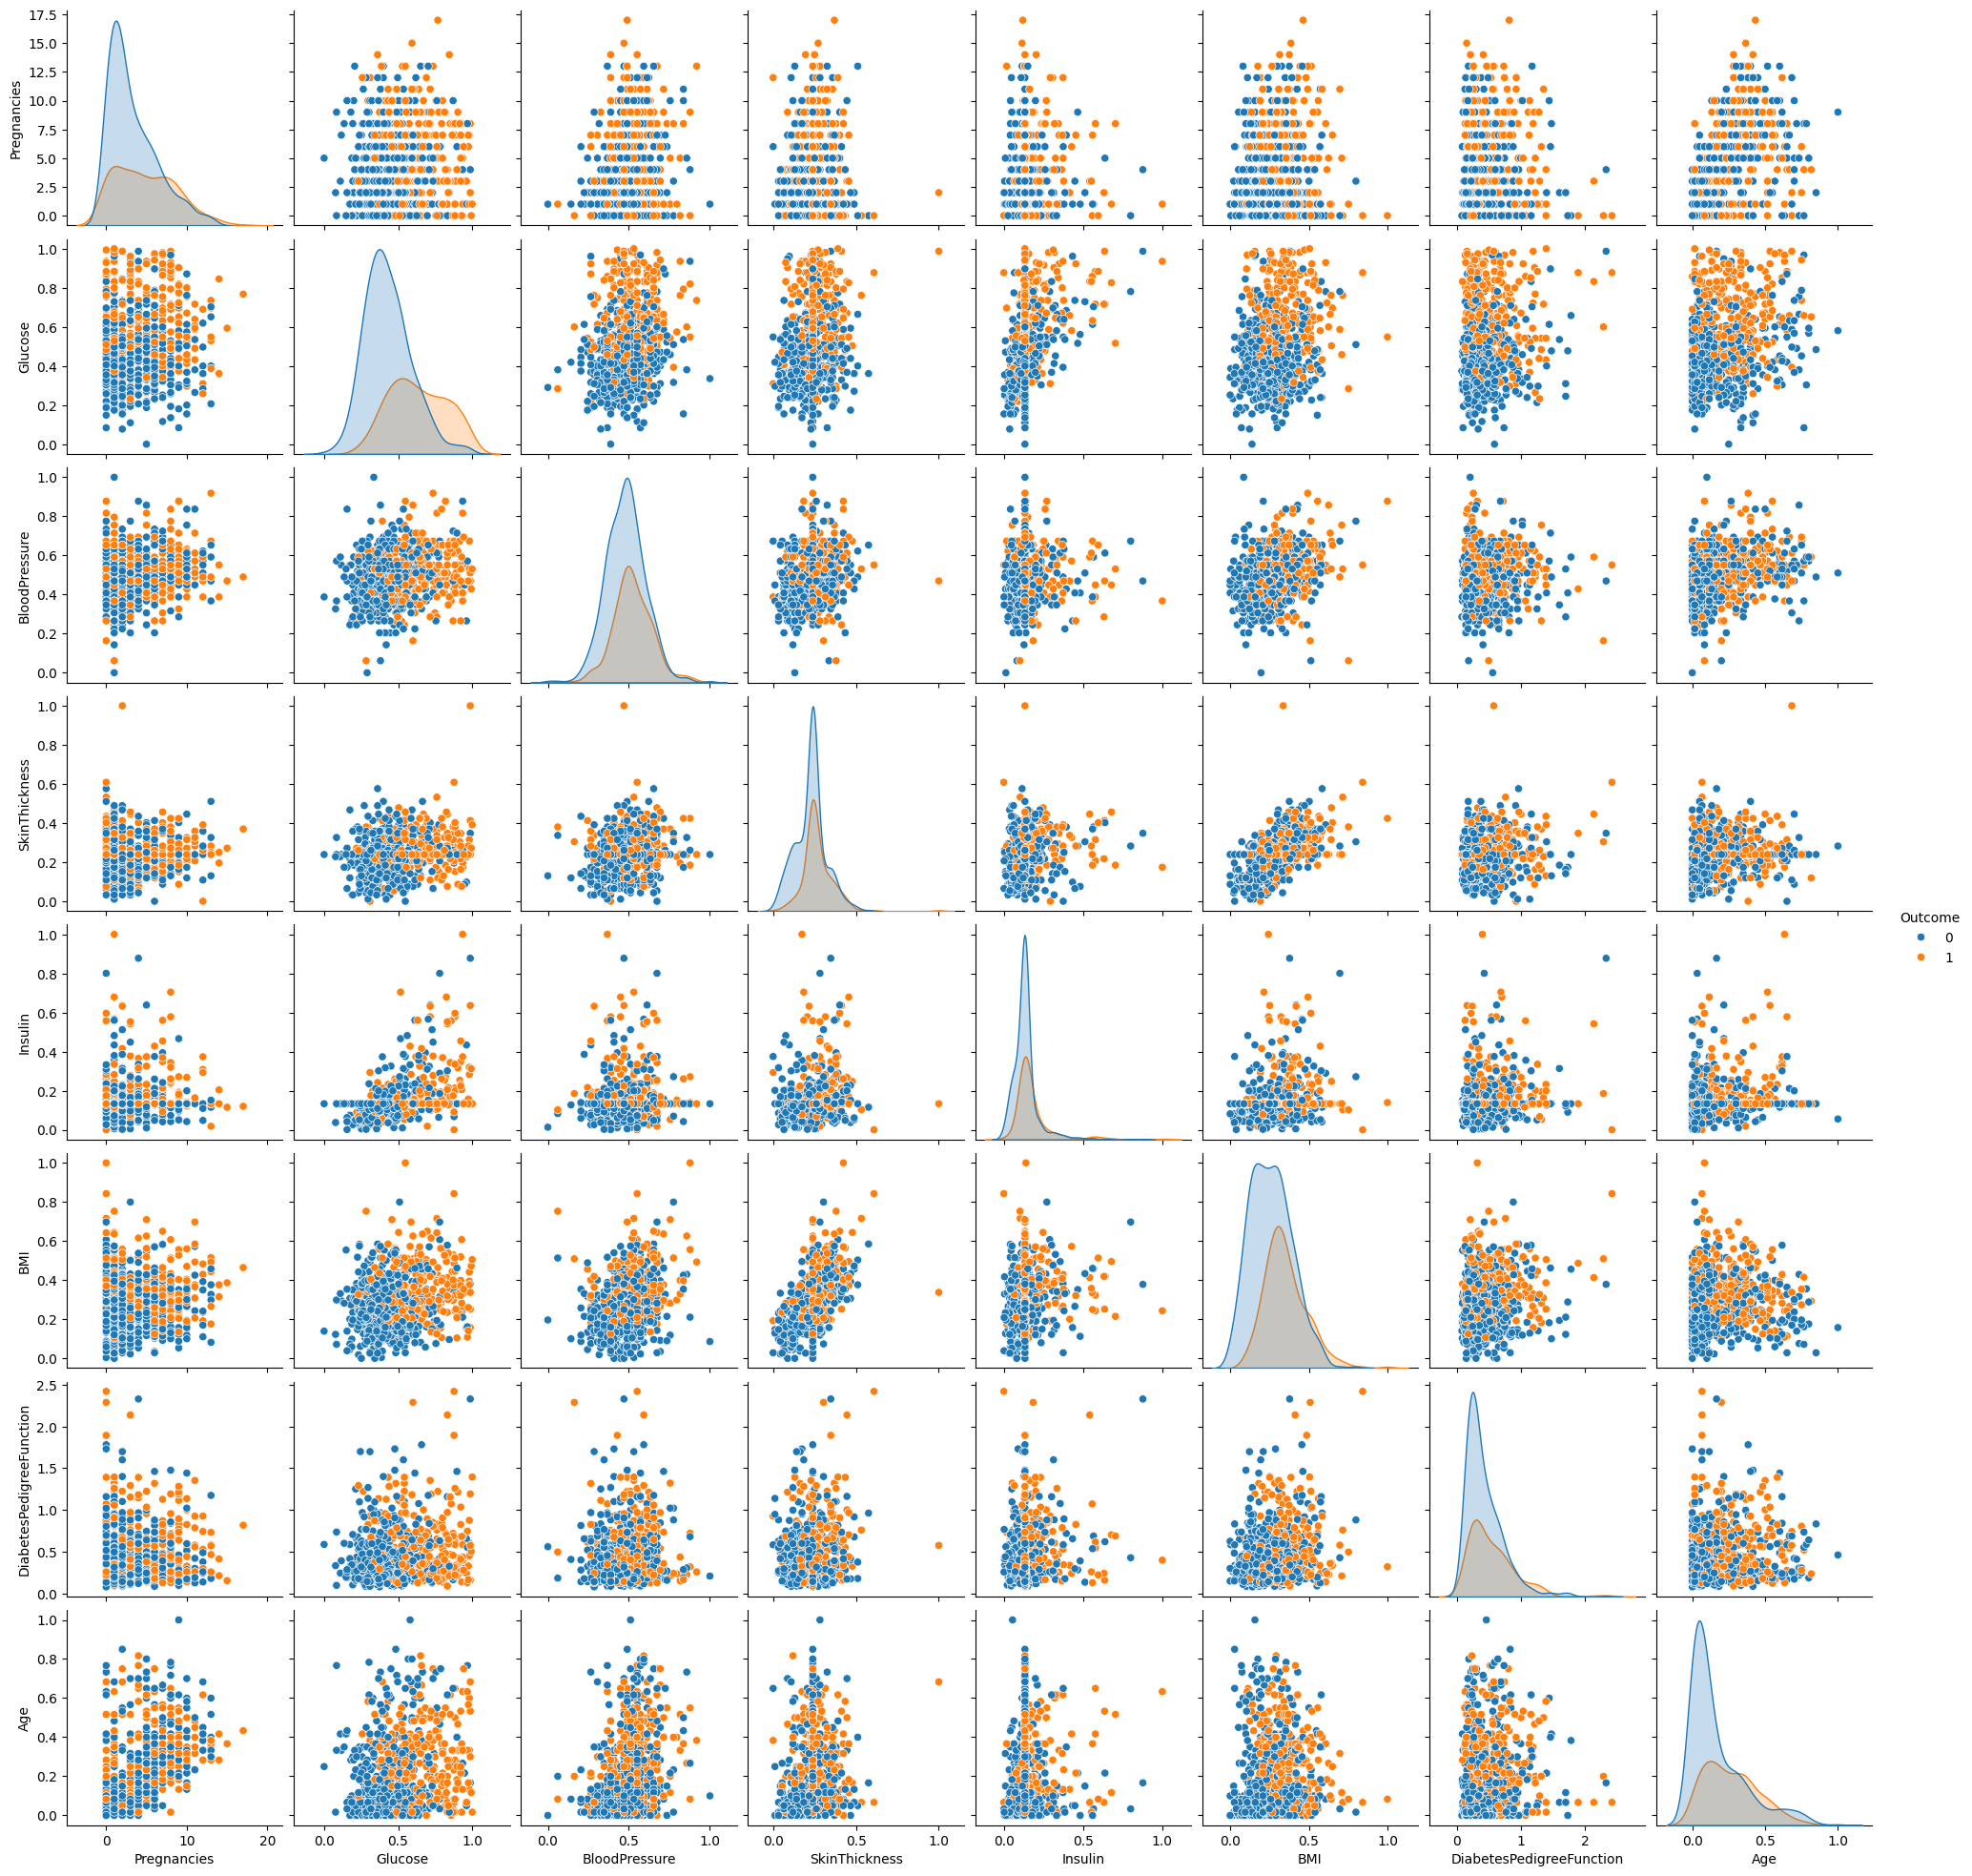

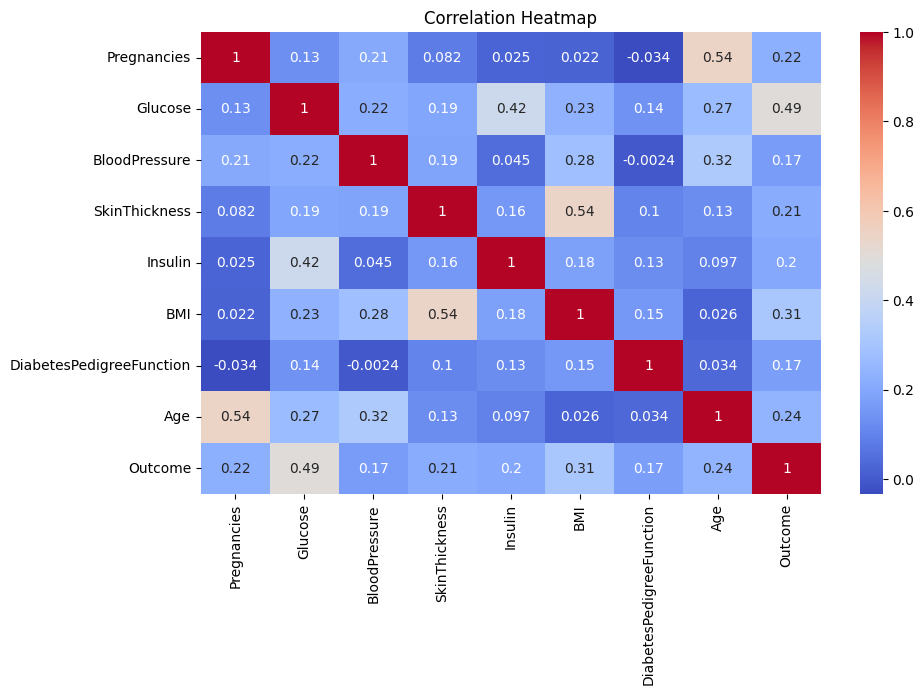

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot of selected features
sns.pairplot(df, hue='Outcome')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [10]:
# Feature selection using Chi-Square
X_chi2 = X.select_dtypes(include=['int64', 'float64'])  # Only numeric features for chi2 test
X_chi2 = pd.DataFrame(X_chi2)
X_chi2 = X_chi2 + 1e-5  # To avoid issues with zero values, especially with chi2

# Apply Chi-Square test
chi2_selector = SelectKBest(chi2, k='all')
X_chi2_selected = chi2_selector.fit_transform(X_chi2, y)

# Create a DataFrame of selected features' scores
chi2_scores = pd.DataFrame({
    'Feature': X_chi2.columns,
    'Chi-Square Score': chi2_selector.scores_
})

# Display top features based on chi2 score
print(chi2_scores.sort_values(by='Chi-Square Score', ascending=False))


                    Feature  Chi-Square Score
0               Pregnancies        111.519401
1                   Glucose         14.336045
7                       Age          8.205288
6  DiabetesPedigreeFunction          5.392567
5                       BMI          5.063860
4                   Insulin          2.255214
3             SkinThickness          1.345555
2             BloodPressure          0.650024


In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_chi2_selected, y, test_size=0.2, random_state=42)

# Initialize classifiers
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier()

# Train models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Build and train DNN (Deep Neural Network)
dnn = Sequential()
dnn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile and train the DNN
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Create a stacking ensemble model
estimators = [('lr', logreg), ('rf', rf), ('gb', gb)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

# Predictions
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)
dnn_preds = (dnn.predict(X_test) > 0.5).astype('int32')  # Convert to binary predictions
stacking_preds = stacking_model.predict(X_test)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [22]:
# Calculate performance metrics
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  # Specificity for class 0
    mcc = matthews_corrcoef(y_true, y_pred)
    return accuracy, f1, auc_score, precision, recall, specificity, mcc

# Evaluate models
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'DNN', 'Stacking Ensemble']
predictions = [logreg_preds, rf_preds, gb_preds, dnn_preds, stacking_preds]
metrics = []

for preds in predictions:
    metrics.append(get_metrics(y_test, preds))

# Create DataFrame for model comparison
metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'F1 Score', 'AUC', 'Precision', 'Recall', 'Specificity', 'MCC'])
metrics_df['Model'] = models
metrics_df.set_index('Model', inplace=True)

print(metrics_df)


                     Accuracy  F1 Score       AUC  Precision    Recall  \
Model                                                                    
Logistic Regression  0.779221  0.666667  0.743434   0.723404  0.618182   
Random Forest        0.746753  0.654867  0.730303   0.637931  0.672727   
Gradient Boosting    0.759740  0.672566  0.744444   0.655172  0.690909   
DNN                  0.733766  0.655462  0.728283   0.609375  0.709091   
Stacking Ensemble    0.746753  0.642202  0.722222   0.648148  0.636364   

                     Specificity       MCC  
Model                                       
Logistic Regression     0.868687  0.506606  
Random Forest           0.787879  0.455490  
Gradient Boosting       0.797980  0.483459  
DNN                     0.747475  0.443906  
Stacking Ensemble       0.808081  0.446292  


<ipython-input-32-1a0cb3204f08>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics_df['Accuracy'], palette='viridis')
<ipython-input-32-1a0cb3204f08>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics_df['F1 Score'], palette='viridis')
<ipython-input-32-1a0cb3204f08>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metrics_df['AUC'], palette='viridis')
<ipython-input-32-1a0cb3204f08>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. A

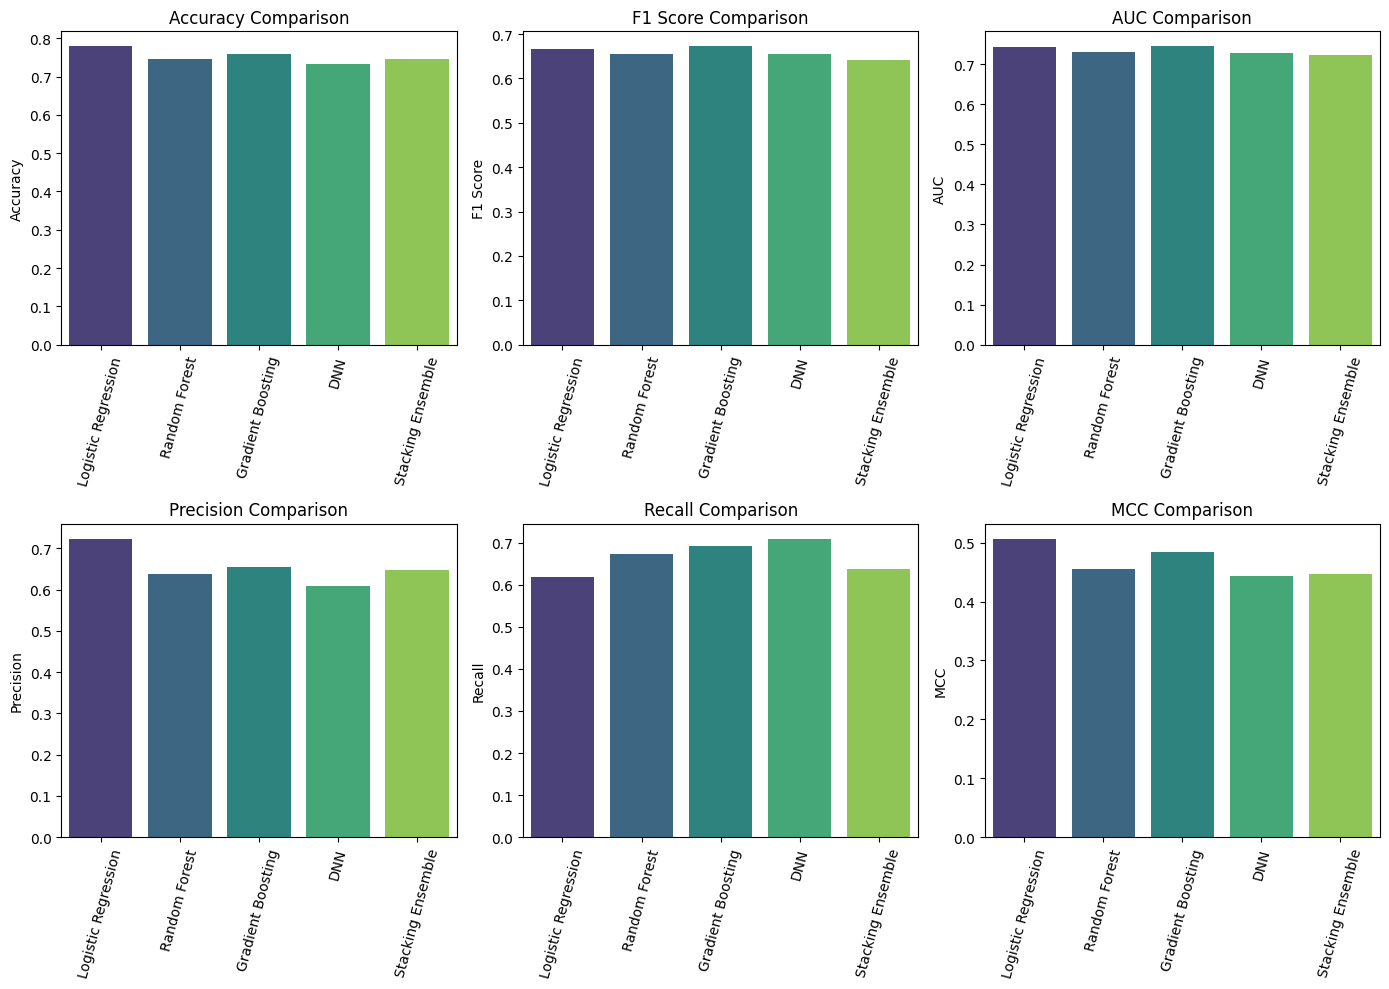

In [32]:
# Plot Comparison Graphs
plt.figure(figsize=(14, 10))

# Accuracy comparison
plt.subplot(2, 3, 1)
sns.barplot(x=models, y=metrics_df['Accuracy'], palette='viridis')
plt.title('Accuracy Comparison')
plt.xticks(rotation=75)

# F1 Score comparison
plt.subplot(2, 3, 2)
sns.barplot(x=models, y=metrics_df['F1 Score'], palette='viridis')
plt.title('F1 Score Comparison')
plt.xticks(rotation=75)


# AUC comparison
plt.subplot(2, 3, 3)
sns.barplot(x=models, y=metrics_df['AUC'], palette='viridis')
plt.title('AUC Comparison')
plt.xticks(rotation=75)


# Precision comparison
plt.subplot(2, 3, 4)
sns.barplot(x=models, y=metrics_df['Precision'], palette='viridis')
plt.title('Precision Comparison')
plt.xticks(rotation=75)


# Recall comparison
plt.subplot(2, 3, 5)
sns.barplot(x=models, y=metrics_df['Recall'], palette='viridis')
plt.title('Recall Comparison')
plt.xticks(rotation=75)


# MCC comparison
plt.subplot(2, 3, 6)
sns.barplot(x=models, y=metrics_df['MCC'], palette='viridis')
plt.title('MCC Comparison')
plt.xticks(rotation=75)

plt.tight_layout()
plt.show()

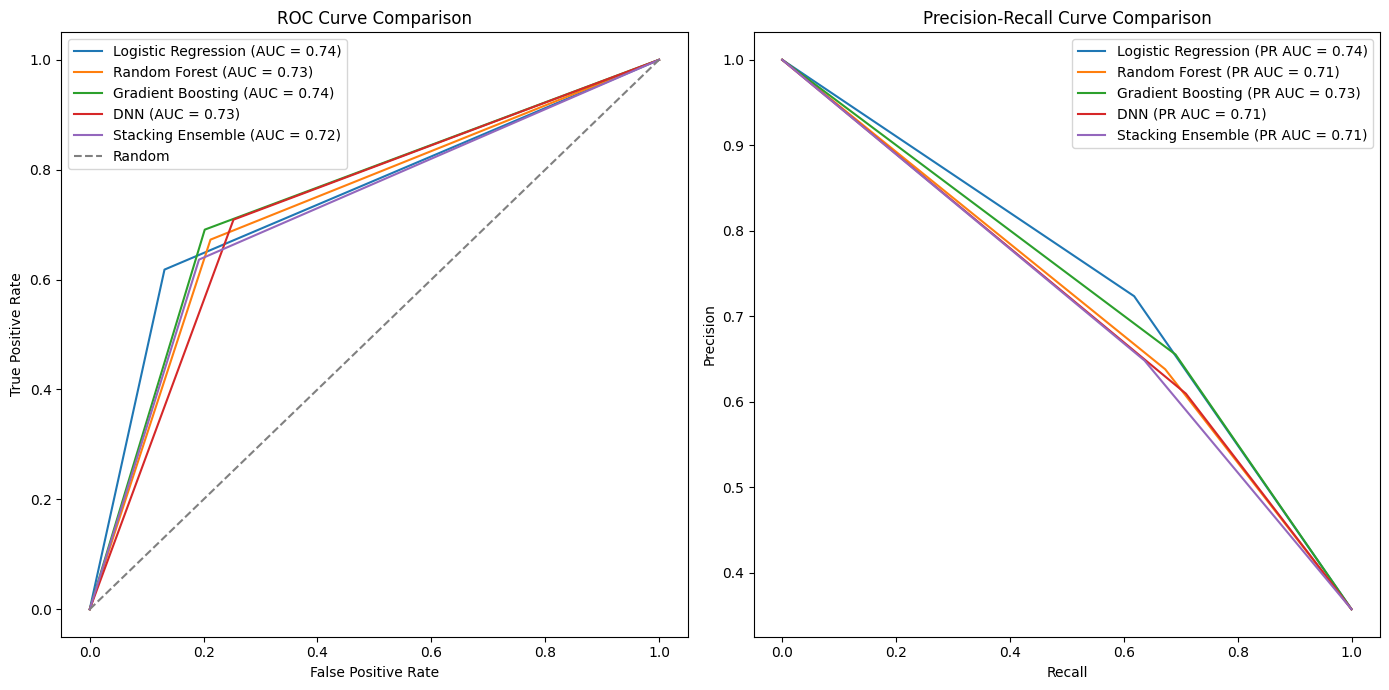

In [26]:
# ROC and PR Curve comparison
plt.figure(figsize=(14, 7))

# ROC Curve
plt.subplot(1, 2, 1)
for preds, model_name in zip(predictions, models):
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='gray')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
for preds, model_name in zip(predictions, models):
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (PR AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()



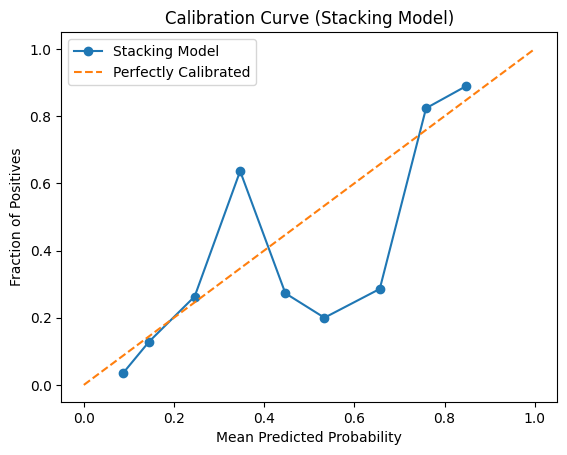

In [25]:
# Calibration curve (for stacking model)
prob_pos = stacking_model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Stacking Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Curve (Stacking Model)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()